On the sdf login node
```
[youtsumi@sdf-login02 u]$ source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/loadLSST.bash                                                                                                        [89/89]
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ setup lsst_distrib
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ jupyter lab
```

Needs an ssh tunnel in a separate window

In [1]:
! eups list -s lsst_distrib

   g7ae64ea4b3+cca76d10ca 	w_latest w_2021_52 current setup


In [2]:
import sys
sys.path.append("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python/mixcoatl/characterizeSpots.py:136: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def run(self, exposure, exposureIdInfo=None):


In [302]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10),facecolor="white")
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/"
butler = Butler(repo_path)

In [52]:
collections=["u/abrought/run_13231/R02_S00/uncorrected","u/abrought/run_13230/R02_S00/uncorrected"]
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [53]:
print(registry)

PostgreSQL@rubin:bot_data_w_2021_43


In [54]:
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/calib
LSSTCam/calib/unbounded
LSSTCam/raw/all
LSSTCam/photodiode/all
u/snyder18/crosstalk_13169/sbias
u/snyder18/crosstalk_13169/sbias/20211215T191900Z
u/snyder18/crosstalk_13169/calib
u/snyder18/crosstalk_13169/crosstalk_spot
u/snyder18/crosstalk_13175/sbias
u/snyder18/crosstalk_13175/sbias/20211217T211636Z
u/snyder18/crosstalk_13186/sbias
u/snyder18/crosstalk_13186/sbias/20211217T225138Z
u/snyder18/crosstalk_13175/calib
u/snyder18/crosstalk_13169/crosstalk_spot/20211218T003408Z
u/snyder18/crosstalk_13175/crosstalk_spot
u/snyder18/crosstalk_13186/calib
u/snyder18/crosstalk_13175/crosstalk_spot/20211218T225100Z
u/snyder18/crosstalk_13186/crosstalk_spot
u/snyder18/crosstalk_13186/crosstalk_spot/20211220T023605Z
u/snyder18/crosstalk_13198/sbias
u/snyder18/crosstalk_13198/sbias/20211220T182307Z
u/snyder18/crosstalk_13198/calib
u/snyder18/crosstalk_13200/sbias
u/snyder18/crosstalk_13200/sbias/20211220T215856Z
u/snyder18/crosstalk_13200/calib
u/snyder18/crosstalk_13200/crosstalk_spo

In [55]:
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3253972 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('photodiode', {band, instrument, physical_filter, exposure}, AstropyTable)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
700 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
2 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
2 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instru

In [257]:
where = """
instrument='LSSTCam'
and detector=9
"""
#and exposure.observation_type = 'spot'
#and exposure.science_program IN ('13232','13234')

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        md = raw.getMetadata()
        # stores into memory for later use

        # Get the peak spot values
        peakSignal = numpy.zeros(len(src))
        s = 15
        if len(src) > 0:
            postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
            image = postisr.getImage().getArray()
            #image = raw.getImage().getArray()
            for i,pt in enumerate(src["spotgrid_index"]):
                x = int(src['base_SdssCentroid_y'][i]) # The coordinate systems are flipped
                y = int(src['base_SdssCentroid_x'][i])

                xmin = max(0,x-s)
                xmax = min(image.shape[0]-1, x+s)
                ymin = max(0,y-s)
                ymax = min(image.shape[1]-1, y+s)
                peakSignal[i] = numpy.max(image[xmin:xmax,ymin:ymax])
    
        newsrc=src.asAstropy()
        newsrc.add_column(peakSignal ,name="peakSignal")
        results.append( {"md": md, "src":newsrc} )
    except:
#        raise
        pass

In [258]:
results[0]["src"]

<Table length=1293>
  id  coord_ra coord_dec parent base_SdssCentroid_x ... spotgrid_normalized_dy spotgrid_normalized_dx spotgrid_index     peakSignal    
        rad       rad                   pix         ...                                                                                
int64 float64   float64  int64        float64       ...        float64                float64             int32           float64      
----- -------- --------- ------ ------------------- ... ---------------------- ---------------------- -------------- ------------------
    1      nan       nan      0  2579.2807049835174 ...                    nan                    nan    -2147483648 207.02174377441406
    2      nan       nan      0  2900.8659778131905 ...    0.36107807581536194    0.20610773328390167            882 247.55221557617188
    3      nan       nan      0    3163.72405445284 ...    0.38495990545776515    0.20794447254080364           1078 203.32041931152344
    4      nan       nan      0   3360.837021328212 ...    0.40477700185130183     0.2090215752499718           1225 213.10208129882812
    5      nan       nan      0     2829.4172212431 ...     0.3564369441319035    0.20510530389597167            834  202.5547637939453
    6      nan       nan      0  2895.1087836750226 ...    0.36054678630062753     0.2050540460266016            883  239.1609344482422
    7      nan       nan      0  2960.7027149235264 ...    0.36612524072525554    0.20364436400012362            932  242.7003631591797
    8      nan       nan      0  3026.4006835132964 ...    0.37347076214857383    0.20397078339161165            981  241.1156768798828
    9      nan       nan      0   3092.029540734922 ...     0.3789313529498741     0.2030823443707382           1030  270.7601623535156
   10      nan       nan      0  3157.5910463174855 ...     0.3855966243688857    0.20127337304724355           1079 225.87347412109375
   11      nan       nan      0  3223.4415534436016 ...    0.39040648871861505    0.20370130971913267           1128  267.6986083984375
   12      nan       nan      0   2560.676566971434 ...    0.32948670318483164    0.20008727916093727            639  261.6295471191406
   13      nan       nan      0  3289.0100480316833 ...      0.398130733806401       0.20209038962547           1177 235.95916748046875
   14      nan       nan      0   2626.317042586786 ...     0.3355776391053115    0.19943021655995932            688 232.68771362304688
  ...      ...       ...    ...                 ... ...                    ...                    ...            ...                ...
 1279      nan       nan      0   3863.651097979629 ...     0.4723806525733658  -0.016604279553349754           1800     1383.986328125
 1280      nan       nan      0  2472.2471107890983 ...    0.33824978407302325  -0.027265837736336007            773   4942.22998046875
 1281      nan       nan      0  3200.8685780870546 ...     0.4125658701191165    -0.0203894173427702           1311   6168.22900390625
 1282      nan       nan      0   3929.375908803238 ...    0.47839289166741333   -0.01598487393538982           1849  777.0813598632812
 1283      nan       nan      0  2537.8810813598243 ...    0.34521334531823117  -0.027946317842366227            822     5265.439453125
 1284      nan       nan      0  3266.5524028222712 ...     0.4188417719529236  -0.020370842533439303           1360     5912.587890625
 1285      nan       nan      0              3995.0 ...     0.4936395035351905  -0.016098400594713957           1898   345.418701171875
 1286      nan       nan      0              2603.0 ...    0.35909202024755504   -0.03586523949915543            871   5304.85498046875
 1287      nan       nan      0              3332.0 ...    0.42096932209410803  -0.024306046627844618           1409    5717.6533203125
 1288      nan       nan      0              4060.0 ...     0.4841542016470524  -0.027850079355176718           1947 220.84317016601562
 1289      nan       nan      0     

In [260]:
from astropy.table import vstack, join
faint = []
for aresult in results:
    if aresult["md"]["EXPTIME"]>13:
        continue
    faint.append(aresult["src"])
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_52/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Table length=2400>
   id   coord_ra coord_dec  parent ... spotgrid_normalized_dy spotgrid_normalized_dx spotgrid_index     peakSignal    
          rad       rad            ...                                                                                
float64 float64   float64  float64 ...        float64                float64             int32           float64      
------- -------- --------- ------- ... ---------------------- ---------------------- -------------- ------------------
    2.0      nan       nan     0.0 ...   0.014004303592454002   0.012278556606885843              0  274.4895477294922
   14.0      nan       nan     0.0 ...   0.014421860235537423   0.011434273429483274              1  306.1584167480469
   35.0      nan       nan     0.0 ...    0.01100569172028758   0.011011113277924478              2  390.2113342285156
   69.0      nan       nan     0.0 ...   0.010775921331263311    0.00957443733526051              3  313.6074981689453
  105.0      nan       nan     0.0 ...   0.010794139868277564   0.009221894392785281              4 357.94837951660156
  143.0      nan       nan     0.0 ...  0.0074648980181841315   0.009195219766148129              5  368.2669372558594
  180.0      nan       nan     0.0 ...   0.008394367239133562   0.008621051909607498              6 428.22906494140625
  218.0      nan       nan     0.0 ...   0.006414313552208486   0.009569350578921436              7   412.249755859375
  256.0      nan       nan     0.0 ...   0.005735782914134119   0.008610272446927303              8 427.92613220214844
  294.0      nan       nan     0.0 ...   0.007096541438270537   0.009315342262428417              9  446.8366241455078
  332.0      nan       nan     0.0 ...  0.0015534264366710406   0.010526538080605998             10  685.9876403808594
  370.5      nan       nan     0.0 ...   0.004559744979891591   0.007669264911204397             11  542.3786010742188
  409.0      nan       nan     0.0 ...  0.0027803650626131533    0.00807916823065633             12  645.4104919433594
  447.0      nan       nan     0.0 ...   0.004383886666711272   0.007024427062272498             13  688.1282043457031
    ...      ...       ...     ... ...                    ...                    ...            ...                ...
 1140.0      nan       nan     0.0 ...     0.0068434150958413  -0.003991506529683997           2386   630.829833984375
 1180.0      nan       nan     0.0 ...  0.0013385148297077102 -0.0044180256875779485           2387  433.0739440917969
 1221.5      nan       nan     0.0 ... -0.0011272163177452799  -0.007588468586553532           2388 373.72569274902344
 1263.0      nan       nan     0.0 ... 0.00025616769791408163  -0.004823461354433264           2389  412.8334655761719
 1302.0      nan       nan     0.0 ...  -0.002273662471383667  -0.005438496366179974           2390  502.9666442871094
 1342.0      nan       nan     0.0 ... -0.0057136130215294425  -0.014315418469850167           2391  452.1852111816406
 1382.0      nan       nan     0.0 ... -0.0013563874590454804  -0.008257809135877828           2392  359.2804718017578
 1421.0      nan       nan     0.0 ...  -0.005045119080657446 -0.0076562391397512405           2393  363.9462127685547
 1460.0      nan       nan     0.0 ... -0.0022324250969228323  -0.007630994496121784           2394  353.8944396972656
 1499.0      nan       nan     0.0 ...  -0.005595377755279268  -0.010137344496771996           2395  340.6522216796875
 1538.0      nan       nan     0.0 ...  -0.006921921088081191  -0.013246637714561561           2396  302.9785919189453
 1578.0      nan       nan     0.0 ...  -0.005992456600373418  -0.011309602957540157           2397  315.6788330078125
 1612.0      nan       nan     0.0 ...  -0.009435878292518683  -0.014596198841221332           2398  273.8675231933594
 1633.0      nan       nan     0.0 ...  -0.006058848708565323  -0.010753291708412433           2399  332.9928894042969
 1644.0      nan       nan     0.0 ...   -0.011854350

In [261]:
exparray = numpy.array([ aresult["md"]["EXPTIME"] for aresult in results ])
exptime=list(set(exparray))

In [262]:
exparray[ numpy.argmin(exparray) ]

1.25

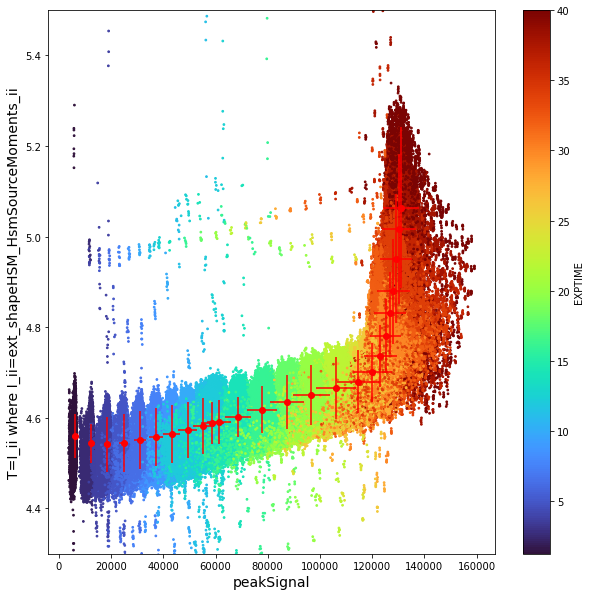

In [298]:
fontsize=14
fig = plt.figure(figsize=(10,10),facecolor="white")

#ykey="ext_shapeHSM_HsmShapeRegauss_sigma"
ykey="base_SdssShape_xx"
#ykey="ext_shapeHSM_HsmSourceMoments_xx"
y2key="base_SdssShape_yy"
#y2key="ext_shapeHSM_HsmSourceMoments_yy"
#xkey="base_CircularApertureFlux_50_0_instFlux"
xkey="peakSignal"
#xkey="base_SdssShape_instFlux"
x = []
y = []
e = []



                
                
for aresult in results[:]:
#    cond = ( aresult["src"]["spotgrid_index"]>=0 ) & ( aresult["src"]["spotgrid_normalized_dx"]**2+aresult["src"]["spotgrid_normalized_dy"]**2<0.002**2 )
    cond = (
        (aresult["src"]["spotgrid_index"]>=0) &
        (aresult["src"]["base_CircularApertureFlux_70_0_instFlux"]>numpy.nanmax(aresult["src"]["base_CircularApertureFlux_70_0_instFlux"])*0.6)
       & ((aresult["src"]["spotgrid_x"]-aresult["src"]["base_SdssCentroid_x"])**2+(aresult["src"]["spotgrid_y"]-aresult["src"]["base_SdssCentroid_y"])**2<1**2)   # cut to reject mis-paired sources
        )
    x.extend(aresult["src"][xkey][cond])
##    y.extend((aresult["src"][ykey]+aresult["src"][y2key])[cond])
    y.extend((aresult["src"][ykey])[cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
e=numpy.array(e)
ax=plt.scatter(x,y,c=e,s=3,cmap='turbo',alpha=1)
for i, _exptime in enumerate(list(set(e))):
    cond = numpy.where(e==_exptime)
    plt.errorbar(
        numpy.nanmedian(x[cond]),
        numpy.nanmedian(y[cond]),
        xerr=numpy.nanstd(x[cond]),
        yerr=numpy.nanstd(y[cond]),
        fmt="o",
        color="red"
    )
    
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("{}".format("T=I_ii where I_ii=ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
#plt.xlim(1e4,0.4e7)
#plt.ylim(9.2,10.2)
plt.ylim(4.3,5.5)
#plt.ylim(1e4,1e8)
plt.colorbar(ax,label="EXPTIME")
#plt.loglog()
#plt.semilogx()


In [265]:
from astropy.table import vstack, join
faint = [ results[i]["src"] for i in  numpy.where(exparray == exptime[2] )[0] ] ### this determines which one from the faintest we are going to base on
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_52/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Table length=2244>
   id   coord_ra coord_dec  parent ... spotgrid_normalized_dy spotgrid_normalized_dx spotgrid_index     peakSignal    
          rad       rad            ...                                                                                
float64 float64   float64  float64 ...        float64                float64             int32           float64      
------- -------- --------- ------- ... ---------------------- ---------------------- -------------- ------------------
  212.0      nan       nan     0.0 ...   0.005304888057945317   0.008780735704731391              8  200.6298065185547
  251.0      nan       nan     0.0 ...     0.0066880624458349   0.008903864881396129              9 206.81846618652344
  288.0      nan       nan     0.0 ...    0.00166505179864978    0.01024834172762889             10 290.33746337890625
    8.0      nan       nan     0.0 ...   0.003947277716847558   0.007294544627774641             11  242.6625213623047
   46.0      nan       nan     0.0 ...   0.003094167368613287  0.0063129429179112845             12     288.2685546875
   84.0      nan       nan     0.0 ...    0.00448462145175713   0.005398648510554912             13 302.95489501953125
  122.0      nan       nan     0.0 ...   0.004163219596234681    0.00474815245993542             14  303.3734436035156
  160.0      nan       nan     0.0 ...    0.00300048314752326   0.005249357282414216             15 327.51898193359375
  199.0      nan       nan     0.0 ...   0.004310194813583375   0.005516523542801825             16  355.8939208984375
  236.0      nan       nan     0.0 ...   0.002242716682066645   0.005726932098296206             17  371.8521728515625
  276.0      nan       nan     0.0 ...   0.004251215482958114   0.005768142397053997             18  410.0357971191406
  315.0      nan       nan     0.0 ...  0.0026201910258449815   0.007522171670838153             19 443.48345947265625
  354.0      nan       nan     0.0 ...   0.003359682377903392  0.0065856724358263185             20  440.0174865722656
  393.0      nan       nan     0.0 ...  0.0036203180212081034   0.006757877210328428             21  485.3651123046875
    ...      ...       ...     ... ...                    ...                    ...            ...                ...
  687.0      nan       nan     0.0 ...   0.002199437948015408  0.0018740995607103865           2375 318.49639892578125
  728.0      nan       nan     0.0 ...  0.0007636247031757411  0.0021517176047116844           2376    319.88330078125
  769.0      nan       nan     0.0 ...  0.0010757873403645904   0.000687019378615707           2377    335.67236328125
  810.0      nan       nan     0.0 ... 0.00023598302885135224  2.890118025612586e-05           2378      287.435546875
  849.0      nan       nan     0.0 ...  0.0011216315741645238 0.00010463422935233328           2379  292.8230438232422
  892.0      nan       nan     0.0 ...  0.0013654838608366708 -0.0015630173452043123           2380  277.8937683105469
  933.0      nan       nan     0.0 ... -0.0006913155948144026 -7.361944664487212e-05           2381 298.75762939453125
  973.0      nan       nan     0.0 ...  0.0015848526337335048  -0.001258190250832962           2382 288.97003173828125
 1013.0      nan       nan     0.0 ...  0.0013442235608979996 -0.0009097668865667277           2383  261.8482971191406
 1053.0      nan       nan     0.0 ...   0.005054311495239546 -0.0019245195470970237           2384  293.5909118652344
 1093.0      nan       nan     0.0 ... -0.0022644343104628343    0.00642611908065945           2385  641.8917236328125
 1133.0      nan       nan     0.0 ...   0.006321452380285253 -0.0052318772335886955           2386  284.8891906738281
 1173.0      nan       nan     0.0 ... 0.00037802862153154794    -0.0046426204753988           2387 204.73731994628906
 1286.0      nan       nan     0.0 ... -0.0022971496183068936  -0.006348748208463796           2390 219.91519165039062
 1324.5      nan       nan     0.0 ...  -0.0058129174

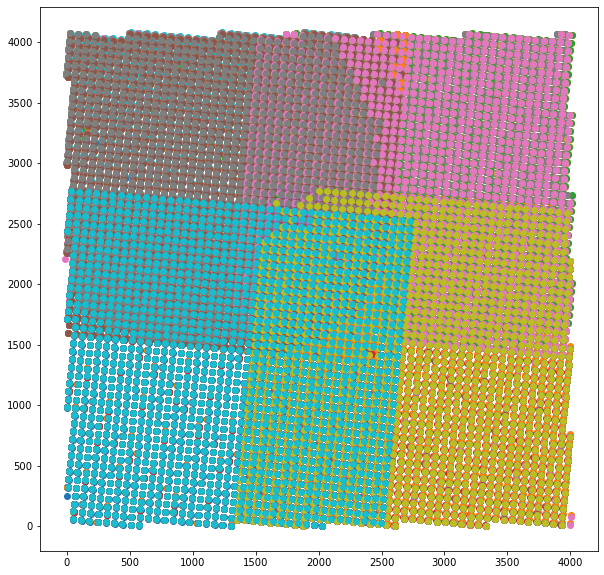

In [266]:
#pylab.scatter(
#    results[0]["src"]["spotgrid_x"],
#    results[0]["src"]["spotgrid_y"]
#)

fig = plt.figure(figsize=(10,10))

for i in range(100):
    pylab.scatter(
        results[i]["src"]["spotgrid_y"],
        results[i]["src"]["spotgrid_x"]
    )

#spotgrid_y	spotgrid_x	spotgrid_normalized_dy	spotgrid_normalized_dx	


<Figure size 720x720 with 0 Axes>

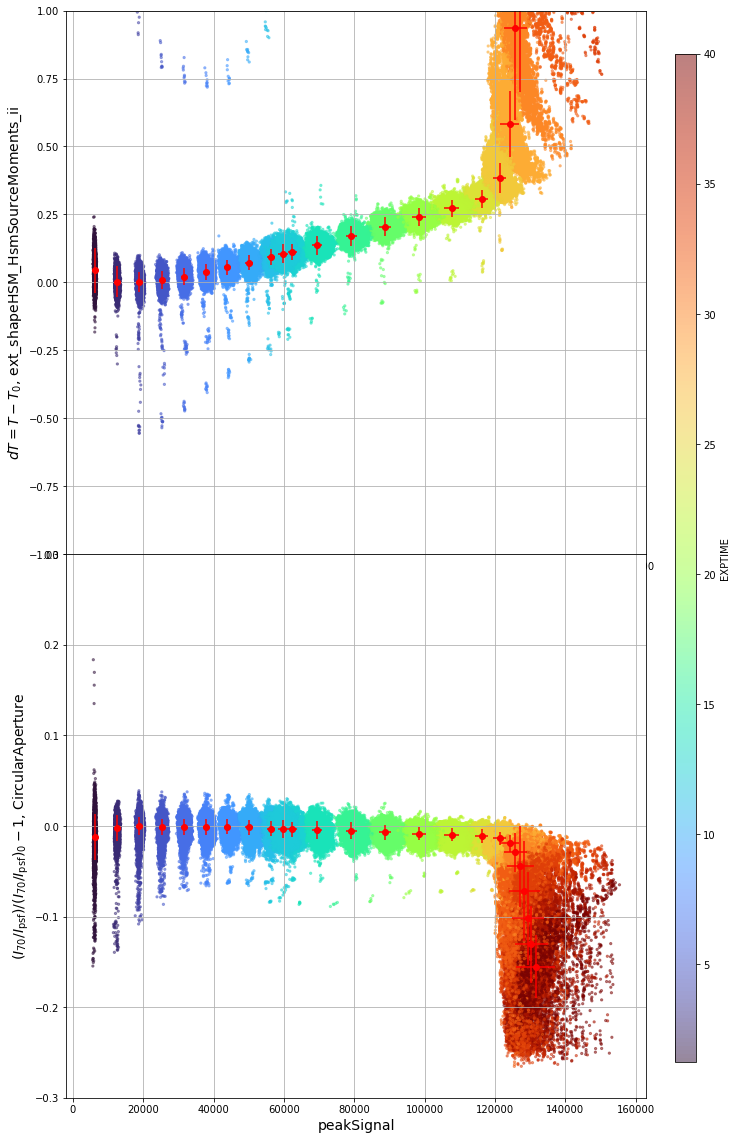

In [288]:
fig = plt.figure(figsize=(10,10),facecolor="white")

from astropy.table import vstack, join

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
xkey="peakSignal"
zskey="base_CircularApertureFlux_3_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"
# ext_shapeHSM_HsmSourceMoments_xx
  
x = []
y = []
zl = []
zs = []
e = []
for aresult in results[:]:
    thistable=aresult["src"]
    joined = join(aresult["src"],ref,keys="spotgrid_index")
    Iperr = joined["base_PsfFlux_instFluxErr_1"]
    Ip = joined["base_PsfFlux_instFlux_1"]    
#    Ierr = joined["{}Err_1".format(xkey)]
    I = joined["{}_1".format(xkey)]
    median=numpy.nanmedian(joined["base_CircularApertureFlux_70_0_instFlux_1"])
    joined = joined[
        numpy.where( 
            ((joined["spotgrid_x_1"]-joined["base_SdssCentroid_x_1"])**2+(joined["spotgrid_y_1"]-joined["base_SdssCentroid_y_1"])**2<2**2) &
#            (joined["base_PixelFlags_flag_1"] == False) &
#            (joined["base_PsfFlux_flag_edge_1"] == False) &
#            (joined["base_CircularApertureFlux_70_0_flag_apertureTruncated_1"] == False) &            
#            (joined["base_ClassificationExtendedness_flag_1"] == False) &
#            (joined["base_PixelFlags_flag_1"] == False) &            
#            (joined["base_PixelFlags_flag_offimage_1"] == False) &
#            (joined["base_PixelFlags_flag_edge_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolated_1"] == False) &
#            (joined["base_PixelFlags_flag_saturated_1"] == False) &            
#            (joined["base_PixelFlags_flag_cr_1"] == False) &
#            (joined["base_PixelFlags_flag_bad_1"] == False) &
#            (joined["base_PixelFlags_flag_suspect_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_saturatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_crCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_suspectCenter_1"] == False) &
#            ((joined["base_CircularApertureFlux_70_0_instFlux_1"]-median)/median<0.01) &  # 
            (joined["base_CircularApertureFlux_70_0_instFlux_1"]>numpy.nanmax(joined["base_CircularApertureFlux_70_0_instFlux_1"])*0.9) # trying to choose center spots
#            (Iperr/Ip<0.01)&
#            (Ierr/I<0.01)            
        )
    ]
    x.extend(joined["{}_1".format(xkey)])
    Y1=joined["{}_1".format(y1key)]
    Y2=joined["{}_1".format(y2key)]
    Y0_1=joined["{}_2".format(y1key)]
    Y0_2=joined["{}_2".format(y2key)]    
    zl.extend(joined["{}_1".format(zlkey)]/joined["{}_2".format(zlkey)])
    zs.extend(joined["{}_1".format(zskey)]/joined["{}_2".format(zskey)])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([aresult["md"]["EXPTIME"]]*len(Y1))
        
x=numpy.array(x)
y=numpy.array(y)
zl=numpy.array(zl)
zs=numpy.array(zs)

fig = plt.figure(figsize=(10,20),facecolor="white")

ax = plt.subplot(211)
sca=ax.scatter(x,y,c=e,s=5,cmap='turbo',alpha=0.5)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1,1)
ax.grid()

e=numpy.array(e)
for i, _exptime in enumerate(list(set(e))):
    cond = numpy.where(e==_exptime)
    plt.errorbar(
        numpy.nanmedian(x[cond]),
        numpy.nanmedian(y[cond]),
        xerr=numpy.nanstd(x[cond]),
        yerr=numpy.nanstd(y[cond]),
        fmt="o",
        color="red"
    )

bx = plt.subplot(212,sharex=ax)
z=zs/zl-1
scb=bx.scatter(x,z,c=e,s=5,cmap='turbo',alpha=0.5)

for i, _exptime in enumerate(list(set(e))):
    cond = numpy.where(e==_exptime)
    plt.errorbar(
        numpy.nanmedian(x[cond]),
        numpy.nanmedian(z[cond]),
        xerr=numpy.nanstd(x[cond]),
        yerr=numpy.nanstd(z[cond]),
        fmt="o",
        color="red"
    )
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,0.55e7)
bx.set_ylim(-.3,.3)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

Text(0.5, 0, 'EXPTIME [s]')

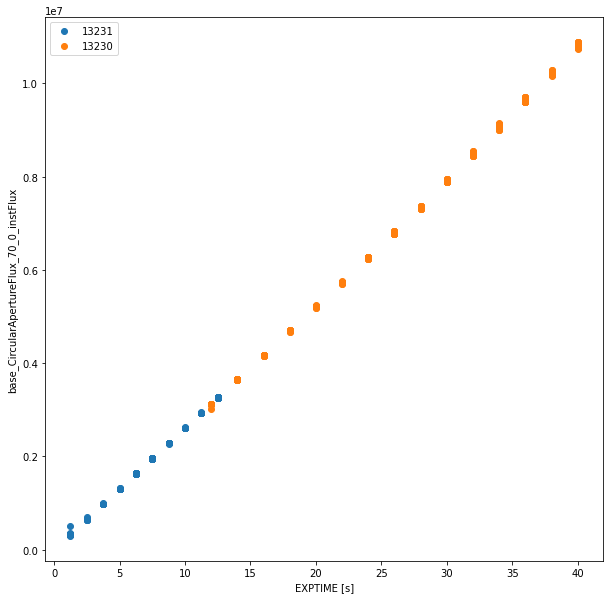

In [272]:
import pylab
fig = plt.figure(figsize=(10,10))

#for a in faint:
peak = []
exp = []
run = []
for b in results:
    peak.append(numpy.nanmax(b["src"]["base_CircularApertureFlux_70_0_instFlux"]))
    exp.append(b["md"]["EXPTIME"])
    run.append(b["md"]["RUNNUM"])

exp=numpy.array(exp)
peak=numpy.array(peak)
run=numpy.array(run)
for arun in list(set(run)):
    print(numpy.where(run == arun))
    pylab.plot(exp[numpy.where(run == arun)],peak[numpy.where(run == arun)],"o",label=arun)
exp.sort()
print(exp)
pylab.legend()
pylab.ylabel("base_CircularApertureFlux_70_0_instFlux")
pylab.xlabel("EXPTIME [s]")

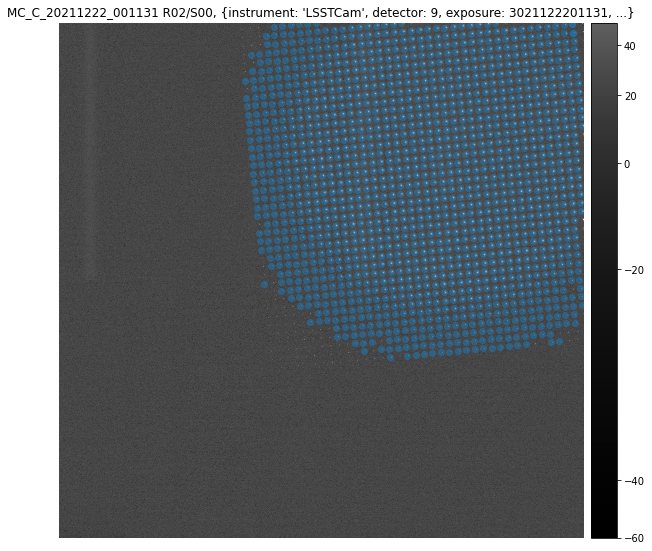

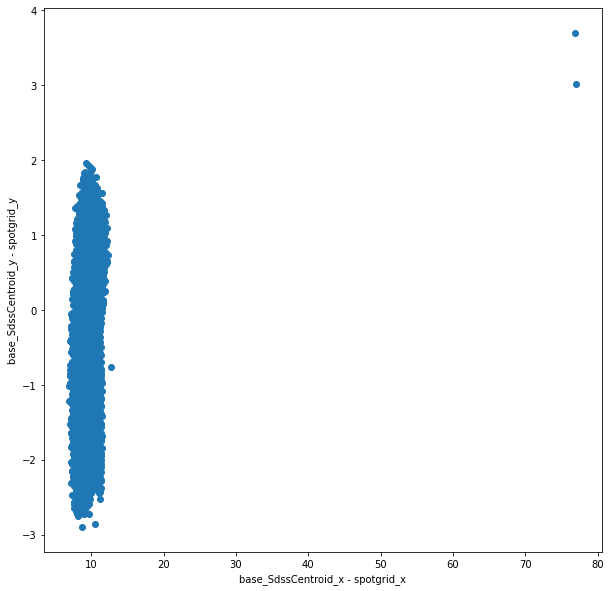

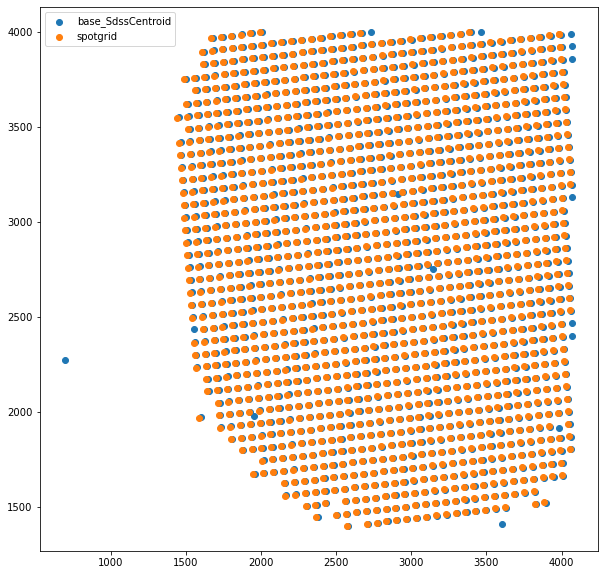

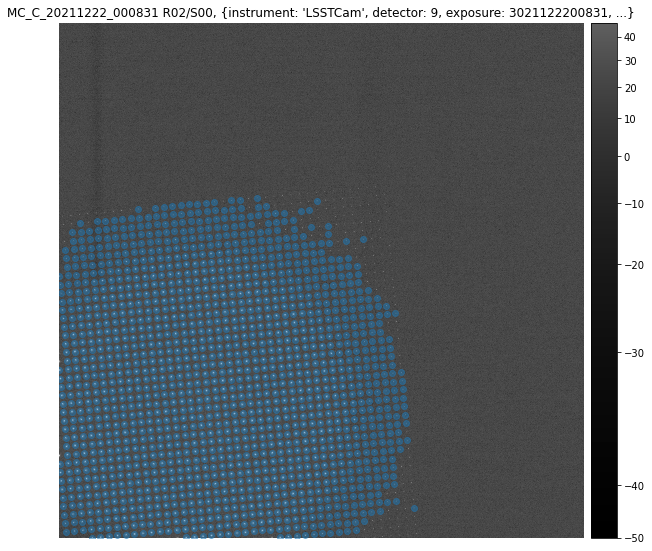

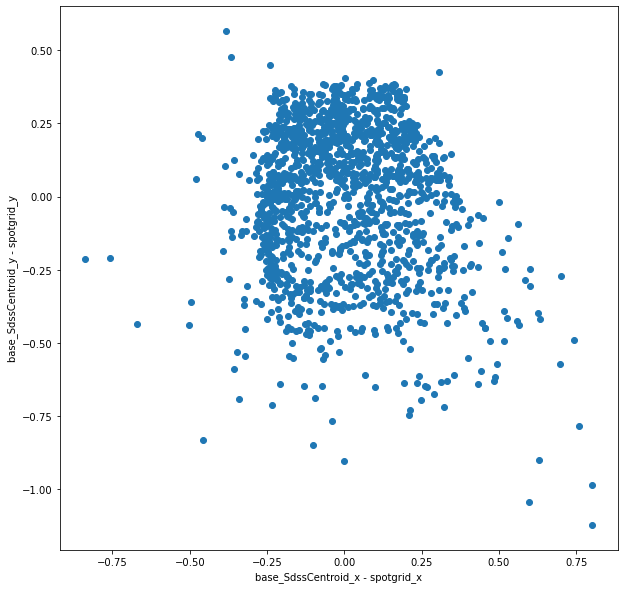

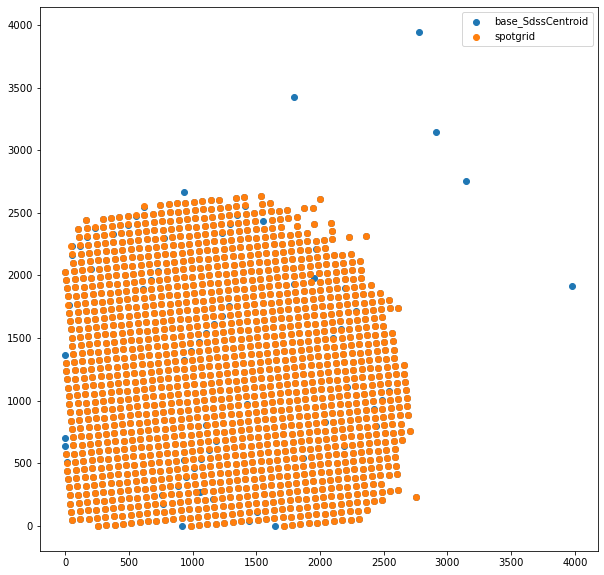

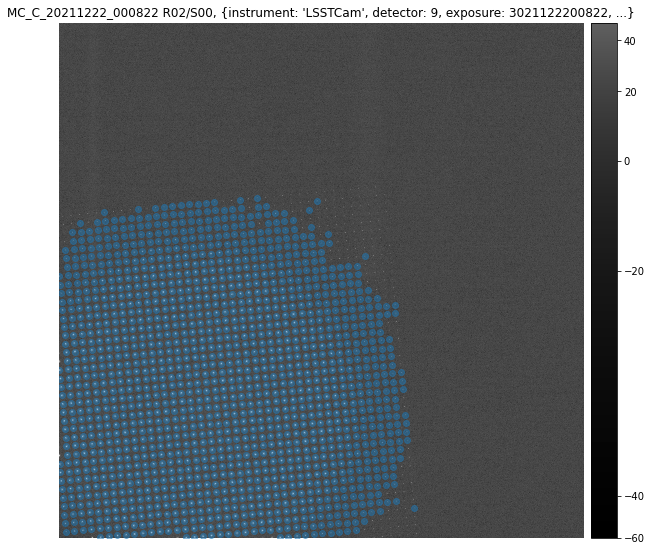

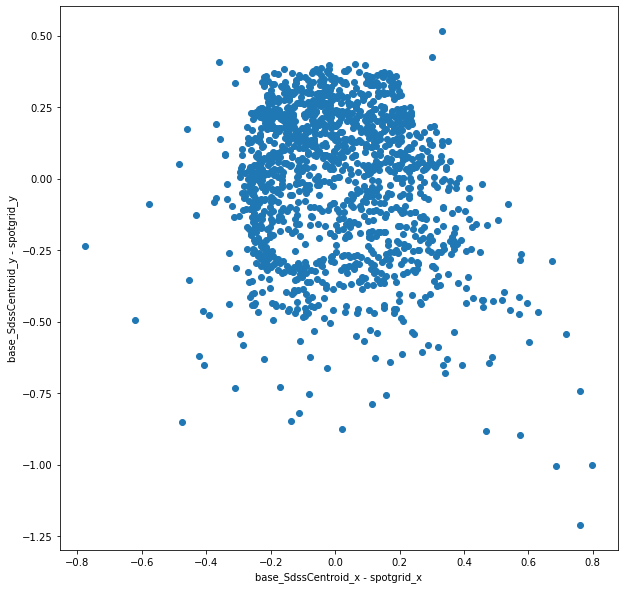

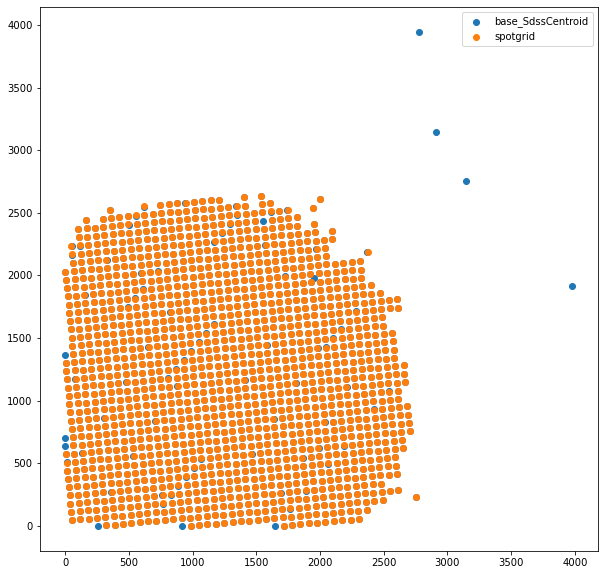

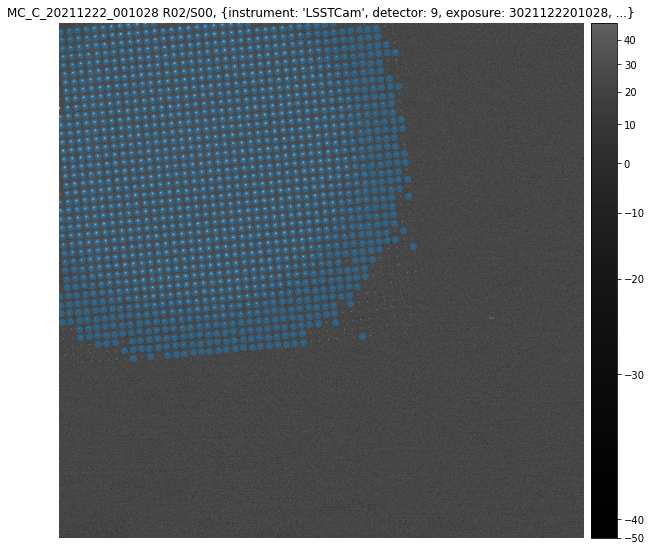

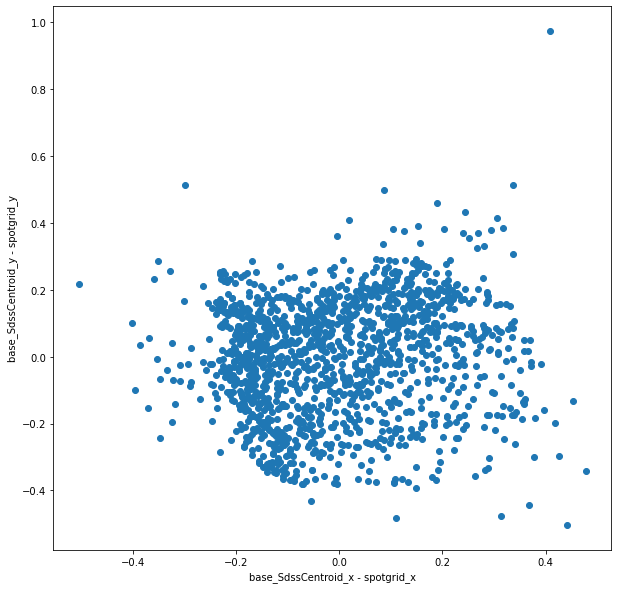

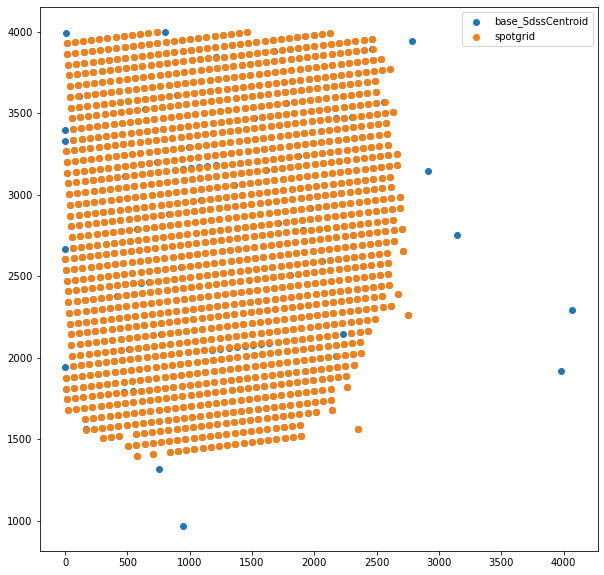

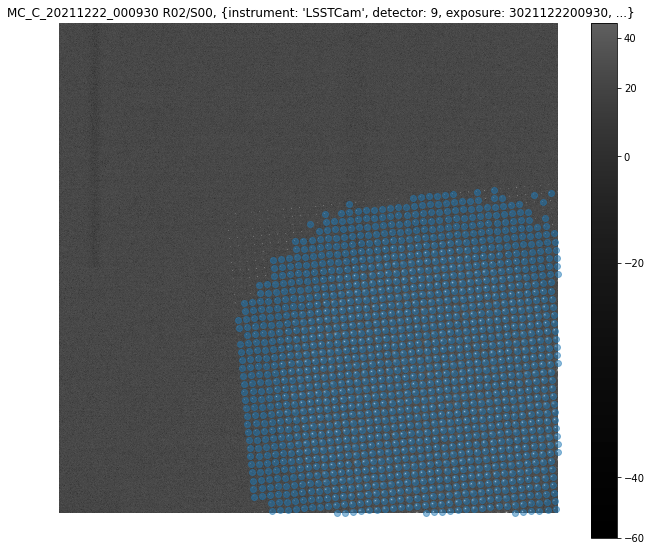

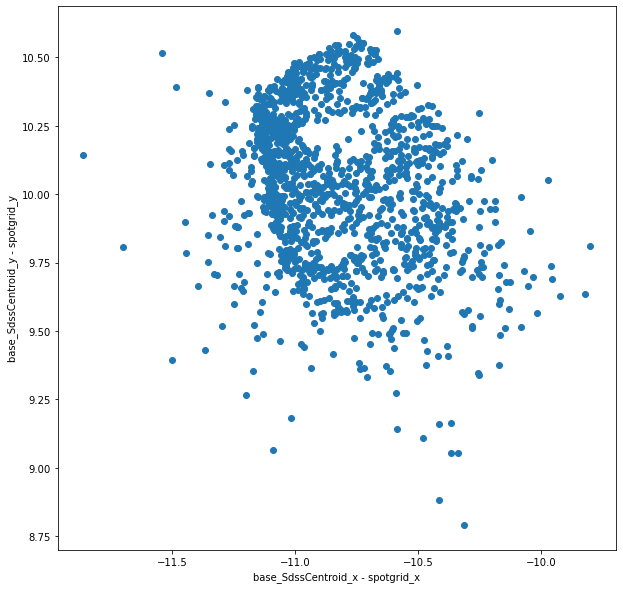

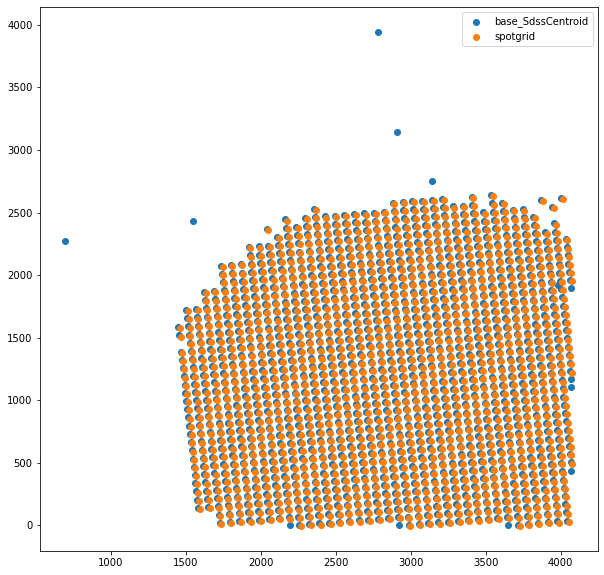

In [303]:
where = """
instrument='LSSTCam'
and detector=9
and exposure.observation_type = 'spot'
and exposure.exposure_time = 2.5
and exposure.science_program IN ('13231')
"""
#-- and exposure.exposure_time 1.25

# gridSpotSrc

datasetRefs = list(subregistry.queryDatasets(
    datasetType="postISRCCD",
    collections=collections,
    where=where)
                  )
subresults = []

for aref in datasetRefs[:5]:
    try:
        # get a catalog from the butler
        raw = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
#        src = subbutler.get("spotSrc",dataId=aref.dataId)
        img = raw.getImage().getArray()
#        print(src.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y","base_SdssShape_instFlux"])
        md = raw.getMetadata()
        x=src["spotgrid_x"]
        y=src["spotgrid_y"]
#        x=src.asAstropy()["slot_Centroid_x"]
#        y=src.asAstropy()["slot_Centroid_y"]
        I=src["base_SdssShape_instFlux"]        
        display(raw)
        pylab.title(f"{md['OBSID']} {md['RAFTBAY']}/{md['CCDSLOT']}, {aref.dataId}")
        pylab.plot(x,y,"o",alpha=0.5)
        pylab.show()
        
        fig = plt.figure(figsize=(10,10),facecolor="white")

        pylab.scatter(
            src["base_SdssCentroid_x"] - src["spotgrid_x"],
            src["base_SdssCentroid_y"] - src["spotgrid_y"]
        )
        pylab.xlabel("base_SdssCentroid_x - spotgrid_x")
        pylab.ylabel("base_SdssCentroid_y - spotgrid_y")
        pylab.show()
        
        fig = plt.figure(figsize=(10,10))

        for key in ["base_SdssCentroid","spotgrid"]:
            pylab.scatter(src[f"{key}_x"],src[f"{key}_y"],label=f"{key}")
        pylab.legend()
        pylab.show()

        print(md["EXPTIME"])
        # stores into memory for later use
        subresults.append( {"md": md, "src":src} )
    except:
#        raise
        pass


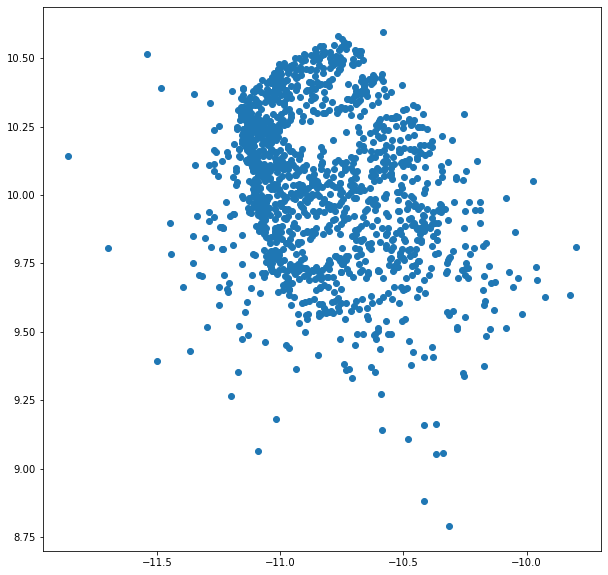

In [279]:
fig = plt.figure(figsize=(10,10))

pylab.scatter(
    src["base_SdssCentroid_x"] - src["spotgrid_x"],
    src["base_SdssCentroid_y"] - src["spotgrid_y"]
)

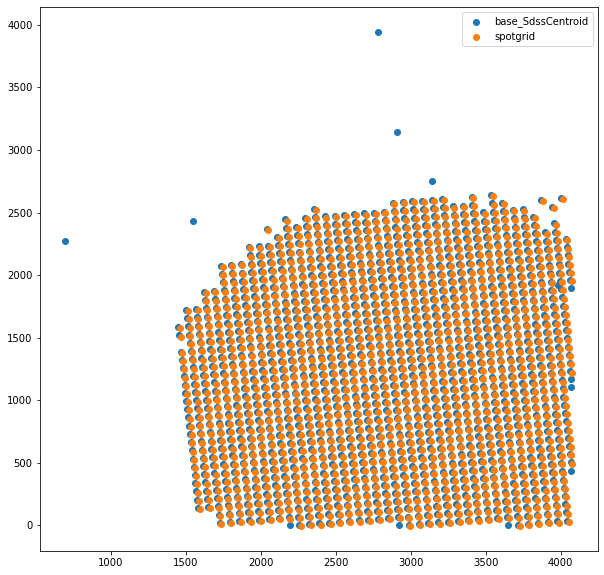

In [282]:
fig = plt.figure(figsize=(10,10))

for key in ["base_SdssCentroid","spotgrid"]:
    pylab.scatter(src[f"{key}_x"],src[f"{key}_y"],label=f"{key}")
pylab.legend()

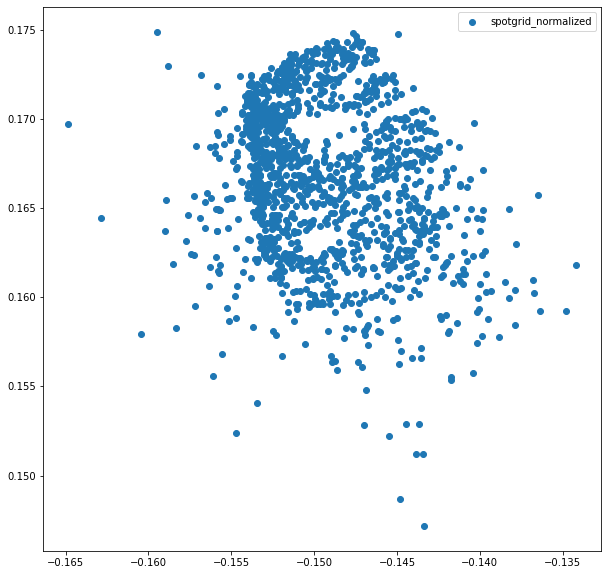

In [283]:
fig = plt.figure(figsize=(10,10))

for key in ["spotgrid_normalized"]:
    pylab.scatter(src[f"{key}_dx"],src[f"{key}_dy"],label=f"{key}")
pylab.legend()


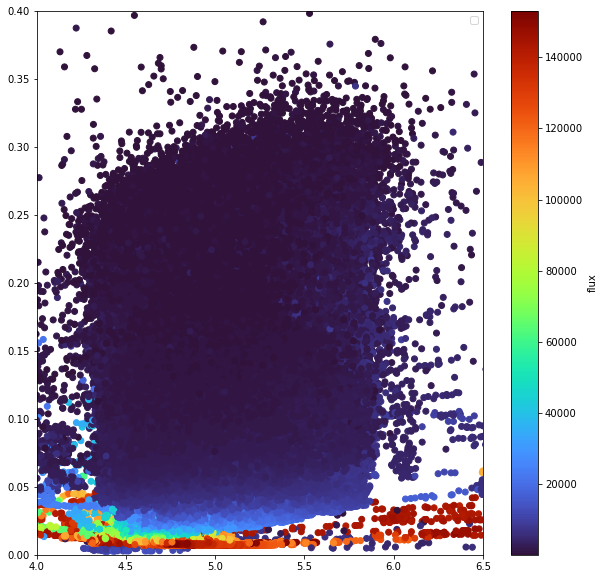

In [294]:
fig = plt.figure(figsize=(10,10))

for aresult in results[::1]:
    try:
#        raw = subbutler.get(aref)
#        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
#        img = raw.getImage().getArray()
#        md = raw.getMetadata()
        src=aresult["src"]

        scb=pylab.scatter(
            src["base_SdssShape_xx"],
            src["base_SdssShape_xxErr"],
            c=src["peakSignal"],
            cmap='turbo'
        )
        
    except:
#        pass
        raise
        
pylab.xlim(4,6.5)
pylab.ylim(0,0.4)
pylab.legend()
pylab.colorbar(scb,label="flux")

[]